In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta

In [2]:
users = pd.read_csv("takehome_users_utf8.csv")
engagement = pd.read_csv("takehome_user_engagement_utf8.csv")

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
users.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

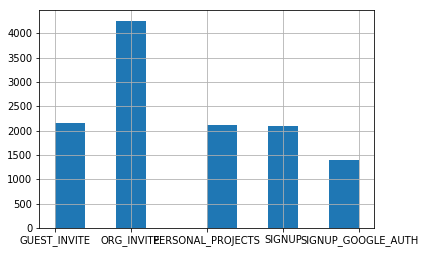

In [6]:
users.creation_source.hist()

In [7]:
engagement.head()

,time_stamp,user_id,visited
0,4/22/2014 3:53,1,1
1,11/15/2013 3:45,2,1
2,11/29/2013 3:45,2,1
3,12/9/2013 3:45,2,1
4,12/25/2013 3:45,2,1


### 1. Find The Adopted Users
Define adopted users as the users who log into the prodcut on 3 separate days in one 7 day period. 

I first break the user engagement down to find users who logged on at least 3 times. Then, I integrate them back in the dataframe `users`.

In [8]:
user_visits = engagement.groupby('user_id').agg({'visited':'count'})
active_users = user_visits.loc[user_visits.visited >= 3].index.values
engagement = engagement.loc[engagement.user_id.isin(active_users)]
engagement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201002 entries, 1 to 207909
Data columns (total 3 columns):
time_stamp    201002 non-null object
user_id       201002 non-null int64
visited       201002 non-null int64
dtypes: int64(2), object(1)
memory usage: 6.1+ MB


In [9]:
# Drop visited, a redundant column
engagement.drop(['visited'], axis=1, inplace=True)

In [10]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201002 entries, 1 to 207909
Data columns (total 2 columns):
time_stamp    201002 non-null object
user_id       201002 non-null int64
dtypes: int64(1), object(1)
memory usage: 4.6+ MB


In [ ]:
# Convert to datetime
engagement.time_stamp = pd.to_datetime(engagement.time_stamp).dt.normalize()
engagement.rename({'time_stamp':'date'}, axis=1, inplace=True)
engagement.head()

In [ ]:
engagement['date'] = pd.to_timedelta(engagement.date)
engagement.rename({'date':'days'}, axis=1, inplace=True)
engagement.head()

In [ ]:
# Create a groupby object based on user_id
engagement_gb = engagement.groupby('user_id')

In [ ]:
# https://github.com/naveenrc/RelaxChallenge/blob/master/RelaxChallenge.ipynb

def find_adopted_users(x):
    """
    Takes property object x
    converts x to list
    returns 1 if a user logged into the product on three separate
    days in at least one seven day period 
    """
    user_history = [i for i in x]  # convert property object to list
    user_history.sort()  # sort the dates in increasing order
    user_history = [user_history[i+1] - user_history[i] for i in range(len(user_history)-2)]  # compute cumulative difference of current and next day
    # sum i, i+1, i+2 terms and check if it`s less than 7 which gives if it`s in a seven day period
    user_history = [1 for i in range(len(user_history)-2) if user_history[i] + user_history[i+1] + user_history[i+2] <= timedelta(days=7)]
    # condition to check if there`s a 1 in x, return 1 if true
    if 1 in user_history:
        return 1

df_adopted_users = engagement_gb.agg(find_adopted_users)  # group by user_id and aggregate using custom function
df_adopted_users.fillna(0, inplace=True)  # fill null values with 0
df_adopted_users.columns = ['adopted_user']
df_adopted_users.head()

In [ ]:
adopted_users = df_adopted_users.loc[df_adopted_users.adopted_user==1].index.values
users['adopted_user'] = users.object_id.apply(lambda x: 1 if x in adopted_users else 0)
users.head(10)

### 2. Data Wrangling and Feature Engineering
Now that the target variable (adopted_user) has been extracted, it's time to compile relevant features. Since this case study deals mostly with categorical data, I'll deal mostly with categorical features. Continuous numerical features (last_session_creation_time, creation_time) don't make much sense here, and neither do misc. identifier information (name, email), so those columns will be dropped. 

In [ ]:
users.drop(['name', 'email', 'org_id','creation_time', 'last_session_creation_time'], axis=1, inplace=True)
users.head(10)

In [ ]:
users.invited_by_user_id = users.invited_by_user_id.apply(lambda x: 0 if np.isnan(x) else 1)

In [ ]:
users.head()

In [ ]:

users.info()

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, Binarizer, LabelBinarizer

In [ ]:
print("adopted users: ", sum(users.adopted_user))
print("total users: ", len(users))
      

### 3. Training and Testing with a decision tree classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, confusion_matrix, recall_score


In [ ]:
users.info()

In [ ]:
users.head(10)


In [ ]:
# le = LabelEncoder()
# le.fit(users.creation_source)
# creation_source_enc = le.transform(users.creation_source)
# users.creation_source = creation_source_enc
# # users.creation_source = users.creation_source.astype('category')
# users.head(10)

In [ ]:
users_copy = users.copy()
# users_copy.opted_in_to_mailing_list = users.opted_in_to_mailing_list.astype('category')
# users_copy.enabled_for_marketing_drip = users.enabled_for_marketing_drip.astype('category')
# users_copy.invited_by_user_id = users.invited_by_user_id.astype('category')
# users_copy.creation_source = users.creation_source.astype('category')
# users_copy.adopted_user = users.adopted_user.astype('category')
#users_copy = pd.get_dummies(users_copy)

feature_cols = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'invited_by_user_id']
enc = OneHotEncoder()
# for col in feature_cols:
#     users_copy[col] = ohe.fit_transform(users_copy[col].values)
X = users_copy[feature_cols].values
y = users_copy.adopted_user.values

#bi = LabelBinarizer()
enc.fit(X)
X = enc.transform(X).toarray()
#y = ohe.fit_transform(y.reshape(-1,1))
#y = bi.fit_transform(y.reshape(-1,1))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42618, stratify=y, test_size=0.3)

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
y_prob = dtc.predict_proba(X_test)

# classification_report(y_test, y_pred)
metrics = {'accuracy':accuracy_score, 
           'precision':precision_score,
           'recall':recall_score,
           'f1':f1_score, 
          }
for metric_name, metric in metrics.items():
    print("{}: {}".format(metric_name, metric(y_test, y_pred)))

In [ ]:
y_pred[y_pred == 1]

In [ ]:
dict(zip(feature_cols, dtc.feature_importances_))

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred)